In [1]:
"""Subtractive Clustering Algorithm
"""
__author__ = 'Daniel Albornoz'


import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix

def subclust2(data, Ra, Rb=0, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb==0:
        Rb = Ra*1.15
        
    scaler = MinMaxScaler()
    scaler.fit(data) 
    ndata = scaler.transform(data)
    
    # 14/05/2020 cambio list comprehensions por distance matrix
    #P = np.array([np.sum([np.exp(-(np.linalg.norm(u-v)**2)/(Ra/2)**2) for v in ndata]) for u in ndata])
    #print(P)
    P = distance_matrix(ndata,ndata)
    alpha=(Ra/2)**2
    P = np.sum(np.exp(-P**2/alpha),axis=0)
   
    centers = []
    i=np.argmax(P)
    C = ndata[i]
    p=P[i]
    centers = [C]
    
    continuar=True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P=P-p*np.array([np.exp(-np.linalg.norm(v-C)**2/(Rb/2)**2) for v in ndata])            
        restarP = True  
        i=np.argmax(P)
        C = ndata[i]
        p=P[i]
        if p>AcceptRatio*pAnt:
            centers = np.vstack((centers,C))
        elif p<RejectRatio*pAnt:
            continuar=False
        else: 
            dr = np.min([np.linalg.norm(v-C) for v in centers])
            if dr/Ra+p/pAnt>=1:
                centers = np.vstack((centers,C))
            else:
                P[i]=0
                restarP = False
        if not any(v>0 for v in P):
            continuar = False
    distancias = [[np.linalg.norm(p-c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)
    return labels, centers

# c1 = np.random.rand(15,2)+[1,1]
# c2 = np.random.rand(10,2)+[10,1.5]
# c3 = np.random.rand(5,2)+[4.9,5.8]
# m = np.append(c1,c2, axis=0)
# m = np.append(m,c3, axis=0)

# r,c = subclust2(m,2)

# plt.figure()
# plt.scatter(m[:,0],m[:,1])
# plt.scatter(c[:,0],c[:,1], marker='X')
# print(c)

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed May  6 17:56:16 2020

@author: Daniel Albornoz

Implementación similar a genfis2 de Matlab.
Sugeno type FIS. Generado a partir de clustering substractivo.

"""
__author__ = 'Daniel Albornoz'

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import time

def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))
    
class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma
    
class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids

    
    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        plt.figure()
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.plot(x,y)
        
class fis:
    def __init__(self):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []
        
   
    
    def genfis(self, data, radii):
    #def genfis(self, data, k):

        start_time = time.time()

        #kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
        #cluster_center = kmeans.cluster_centers_
        #labels = kmeans.labels_

        labels, cluster_center = subclust2(data, radii)
        
        #print("--- %s seconds ---" % (time.time() - start_time))
        n_clusters = len(cluster_center)
        
        cluster_center = cluster_center[:,:-1]
        P = data[:,:-1]
        #T = data[:,-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)       
     
        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        self.rules = cluster_center
        self.entrenar(data)

    def entrenar(self, data):
        P = data[:,:-1]
        T = data[:,-1]
        #___________________________________________
        # MINIMOS CUADRADOS (lineal)
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs])
        f = [np.prod(gaussmf(P,cluster,sigma),axis=1) for cluster in self.rules]
        
        nivel_acti = np.array(f).T
        #print("nivel acti")
        #print(nivel_acti)
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        #print("sumMu")
        #print(sumMu)
        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]
        
        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        
        
        A = acti*inp/sumMu
        
        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu
        
        b = T

        solutions, residuals, rank, s = np.linalg.lstsq(A,b,rcond=None)
        self.solutions = solutions #.reshape(n_clusters,n_vars)
        #print(solutions)
        return 0

    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
         
        P = np.c_[data, np.ones(len(data))]
        
        n_vars = P.shape[1]
        n_clusters = len(self.rules)
        
        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions
        
        return np.sum(acti*inp*coef/sumMu,axis=1)
        
    
    def viewInputs(self):
        for input in self.inputs:
            input.view()
        



# Muestra de datos

(151,)


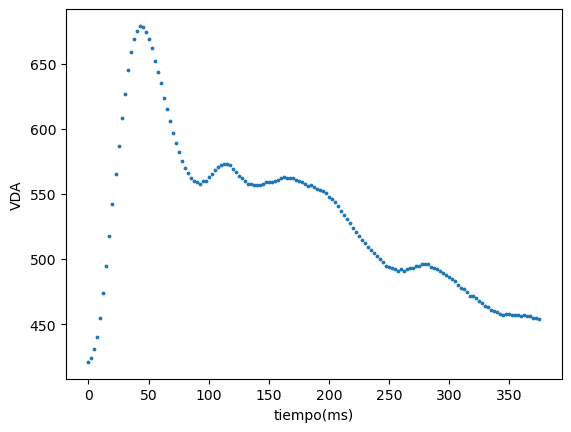

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def leerArchivo(nameFile):
    f = pd.read_csv(nameFile, header = None, engine='python')
    return f.values


arr = leerArchivo("samplesVDA1.txt")
arr2 = np.array(arr)
arr2 = np.concatenate(arr2,axis=0)
n = arr2.size


matrix = np.arange(0,2.5*n,2.5)
matrix.reshape(n,)

print(matrix.shape)
matrix = np.stack(matrix)
arr2 = np.stack(arr2)

matrix=np.stack((matrix,arr2),axis=-1)

plt.xlabel('tiempo(ms)')
plt.ylabel('VDA')
plt.scatter(matrix[:,0],matrix[:,1],s=3)

### Generacion modelo de sugeno con los datos de la coleccion y el parametro del radio de vecindad

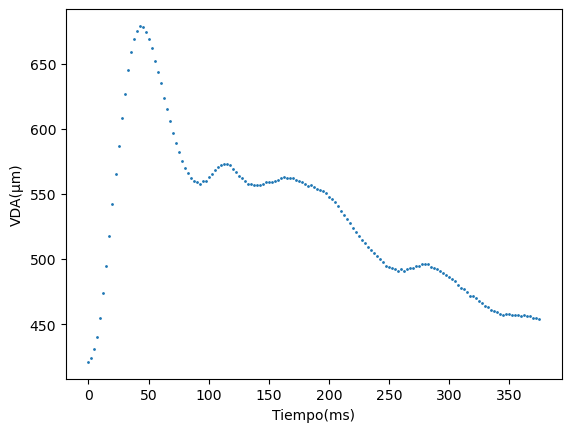

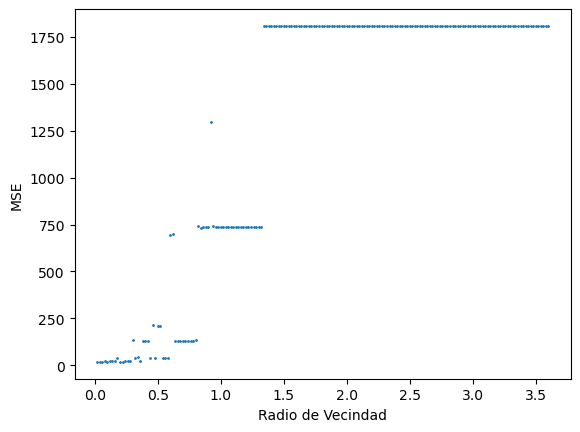

Radio optimo  0.02


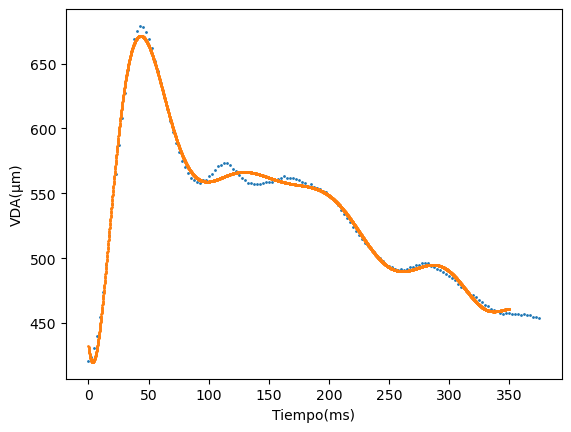

In [20]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt


def leerArchivo(nameFile):
    f = pd.read_csv(nameFile,header = None, engine='python')
    return f.values

data = leerArchivo("samplesVDA1.txt")

n, _ = data.shape
x = np.arange(0, n) * 2.5
x = x.reshape((n, 1))
puntosYTiempos = np.hstack((x,data))

resultModel = fis()
size = 180
radio = 0.
mse = np.zeros((size, 2))


for i in range(size):
    radio += 0.020
    resultModel.genfis(puntosYTiempos, radio) #calculo fis con los datos para el siguiente radio de vecindad
    mse[i,1] = metrics.mean_squared_error(puntosYTiempos[:,1],resultModel.evalfis(x))  #comparo resultado predecido con el target y calculo error
    mse[i,0] = radio #coloco radio de vecindad



radioOptimo = mse[np.argmin(mse[:,1]), 0]
resultModel.genfis(puntosYTiempos, radioOptimo)
X = np.arange(0,350,0.1)
Y = resultModel.evalfis(np.vstack(X))


plt.xlabel('Tiempo(ms)')
plt.ylabel('VDA(µm)')
plt.scatter(puntosYTiempos[:,0],puntosYTiempos[:,1], s=1)
plt.show()


plt.xlabel('Radio de Vecindad')
plt.ylabel('MSE')
plt.scatter(mse[:,0],mse[:,1], s=1)
plt.show()

print("Radio optimo ", radioOptimo)

plt.xlabel('Tiempo(ms)')
plt.ylabel('VDA(µm)')
plt.scatter(puntosYTiempos[:,0],puntosYTiempos[:,1], s=1)
plt.scatter(X,Y, s=1)
plt.show()